# Comparing Tikhonet and SCORE

In this Notebook we are going to evaluate the performance of a [Tikhonet](https://arxiv.org/pdf/1911.00443.pdf) trained.

## Required Libraries and Functions

In [1]:
%matplotlib inline
import sys

data_path = './'

# Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import fft
import pickle

In [2]:
f = open(data_path+"cfht_data.pkl", "rb")
data = pickle.load(f)
f.close()

In [3]:
data.keys(),data['flux'].keys()

(dict_keys(['flux', 'mse', 'mse_w', 'mom', 'windows', 'window_flags', 'mag_auto']),
 dict_keys(['sparsity', 'score', 'tikhonet', 'tikhonet_sc', 'true']))

### Load data and compute errors

In [4]:
# load windows and flags
windows = data['windows']
window_flags = data['window_flags']

# load adaptive moments
mom_g0 = data['mom']['tikhonet']
mom_s0 = data['mom']['sparsity']
mom_s1 = data['mom']['score']
mom_g05 = data['mom']['tikhonet_sc']
mom_hst = data['mom']['true']

# load flux
flux_g0 = data['flux']['tikhonet']
flux_s0 = data['flux']['sparsity']
flux_s1 = data['flux']['score']
flux_g05 = data['flux']['tikhonet_sc']
flux_true = data['flux']['true']

# compute relative pixel errors
mse_g0 = data['mse']['tikhonet']
mse_s0 = data['mse']['sparsity']
mse_s1 = data['mse']['score']
mse_g05 = data['mse']['tikhonet_sc']

# compute winodwed pixel relative errors
mse_g0_w = data['mse_w']['tikhonet']
mse_s0_w = data['mse_w']['sparsity']
mse_s1_w = data['mse_w']['score']
mse_g05_w = data['mse_w']['tikhonet_sc']

# compute adapative moments errors
mom_err_g0 = np.abs(mom_g0-mom_hst)
mom_err_s0 = np.abs(mom_s0-mom_hst)
mom_err_s1 = np.abs(mom_s1-mom_hst)
mom_err_g05 = np.abs(mom_g05-mom_hst)

#compute flux relative errors
flux_err_g0 = np.abs(flux_g0 - flux_true) / flux_true
flux_err_g05 = np.abs(flux_g05 - flux_true) /flux_true
flux_err_s0 = np.abs(flux_s0 - flux_true) / flux_true
flux_err_s1 = np.abs(flux_s1 - flux_true) /flux_true

### Compute Errors per Bin

In [5]:
label_s0 = r'SRA'
label_s1 = r'SCORE'
label_g0 = r'Tikhonet'
label_g05 = r'ShapeNet'

color_g0 = 'green'
color_g05 = 'darkgreen'
color_s0 = 'blue'
color_s1 = 'darkblue'

## Warning: Window Estimation Failures Are Filtered

As shown in the cell below, one third of the window estimation fail. As a first approach we tackle this problem by removing the failures from the analyzed data. 

In [6]:
print('Proportion of failed window estimations: {}'.format(1-window_flags.sum()/window_flags.size))

Proportion of failed window estimations: 0.34342447916666663


### Computing Errors

In [7]:
# Filter the data
original_indices = np.arange(window_flags.size)[window_flags]

# compute pixel errors
mse_g0_win = mse_g0[window_flags]
mse_s1_win = mse_s1[window_flags]
mse_s0_win = mse_s0[window_flags]
mse_g05_win = mse_g05[window_flags]

# compute winodwed relative pixel errors
mse_g0_win_w = mse_g0_w[window_flags]
mse_s1_win_w = mse_s1_w[window_flags]
mse_s0_win_w = mse_s0_w[window_flags]
mse_g05_win_w = mse_g05_w[window_flags]

# compute adapative moments errors
mom_err_g0_win = mom_err_g0[:,window_flags]
mom_err_s1_win = mom_err_s1[:,window_flags]
mom_err_s0_win = mom_err_s0[:,window_flags]
mom_err_g05_win = mom_err_g05[:,window_flags]

# compute fluxipticity errors
flux_err_g0_win = flux_err_g0[window_flags]
flux_err_s1_win = flux_err_s1[window_flags]
flux_err_s0_win = flux_err_s0[window_flags]
flux_err_g05_win = flux_err_g05[window_flags]


# MAKING MAG BINS
# Binning parameters
n_bins = 4
lower_bound = np.min(data['mag_auto'][window_flags])
mag_quantiles = []
mag_means =[]

# computing mean and standard deviation of adapative moments error per binned magnitude

mom_mean_g0 = []
mom_mean_s1 = []
mom_mean_s0 = []
mom_mean_g05 = []

mom_std_g0 = []
mom_std_s1 = []
mom_std_s0 = []
mom_std_g05 = []

# computing mean and standard deviation of fluxipticity error per binned magnitude

flux_mean_g0 = []
flux_mean_s1 = []
flux_mean_s0 = []
flux_mean_g05 = []

flux_std_g0 = []
flux_std_s1 = []
flux_std_s0 = []
flux_std_g05 = []

# computing mean and standard deviation of relative mse error per binned magnitude

mse_mean_g0 = []
mse_mean_s1 = []
mse_mean_s0 = []
mse_mean_g05 = []

mse_std_g0 = []
mse_std_s1 = []
mse_std_s0 = []
mse_std_g05 = []

mse_mean_g0_w = []
mse_mean_s1_w = []
mse_mean_s0_w = []
mse_mean_g05_w = []

mse_std_g0_w = []
mse_std_s1_w = []
mse_std_s0_w = []
mse_std_g05_w = []

for i in range(n_bins-1):
    q = np.quantile(data['mag_auto'][window_flags],(i+1)/n_bins)
    ind = np.logical_and(lower_bound<=data['mag_auto'][window_flags],data['mag_auto'][window_flags]<q)
    mag_quantiles += [q]
    mag_means += [np.mean(data['mag_auto'][window_flags][ind])]
    lower_bound = q
    mom_mean_g0 += [np.mean(np.abs(mom_err_g0_win[:,ind]),axis=1)]
    mom_mean_s1 += [np.mean(np.abs(mom_err_s1_win[:,ind]),axis=1)]
    mom_mean_s0 += [np.mean(np.abs(mom_err_s0_win[:,ind]),axis=1)]
    mom_mean_g05 += [np.mean(np.abs(mom_err_g05_win[:,ind]),axis=1)]

    mom_std_g0 += [np.std(np.abs(mom_err_g0_win[:,ind]),axis=1)]
    mom_std_s1 += [np.std(np.abs(mom_err_s1_win[:,ind]),axis=1)]
    mom_std_s0 += [np.std(np.abs(mom_err_s0_win[:,ind]),axis=1)]
    mom_std_g05 += [np.std(np.abs(mom_err_g05_win[:,ind]),axis=1)]
    
    flux_mean_g0 += [np.mean(np.abs(flux_err_g0_win[ind]))]
    flux_mean_s1 += [np.mean(np.abs(flux_err_s1_win[ind]))]
    flux_mean_s0 += [np.mean(np.abs(flux_err_s0_win[ind]))]
    flux_mean_g05 += [np.mean(np.abs(flux_err_g05_win[ind]))]

    flux_std_g0 += [np.std(np.abs(flux_err_g0_win[ind]))]
    flux_std_s1 += [np.std(np.abs(flux_err_s1_win[ind]))]
    flux_std_s0 += [np.std(np.abs(flux_err_s0_win[ind]))]
    flux_std_g05 += [np.std(np.abs(flux_err_g05_win[ind]))]
    
    mse_mean_g0 += [np.mean(mse_g0_win[ind])]
    mse_mean_s1 += [np.mean(mse_s1_win[ind])]
    mse_mean_s0 += [np.mean(mse_s0_win[ind])]
    mse_mean_g05 += [np.mean(mse_g05_win[ind])]

    mse_std_g0 += [np.std(mse_g0_win[ind])]
    mse_std_s1 += [np.std(mse_s1_win[ind])]
    mse_std_s0 += [np.std(mse_s0_win[ind])]
    mse_std_g05 += [np.std(mse_g05_win[ind])]
    
    mse_mean_g0_w += [np.mean(mse_g0_win_w[ind])]
    mse_mean_s1_w += [np.mean(mse_s1_win_w[ind])]
    mse_mean_s0_w += [np.mean(mse_s0_win_w[ind])]
    mse_mean_g05_w += [np.mean(mse_g05_win_w[ind])]

    mse_std_g0_w += [np.std(mse_g0_win_w[ind])]
    mse_std_s1_w += [np.std(mse_s1_win_w[ind])]
    mse_std_s0_w += [np.std(mse_s0_win_w[ind])]
    mse_std_g05_w += [np.std(mse_g05_win_w[ind])]
    
# LAST BIN BEGIN
ind = lower_bound<=data['mag_auto'][window_flags]
mom_mean_g0 += [np.mean(np.abs(mom_err_g0_win[:,ind]),axis=1)]
mom_mean_s1 += [np.mean(np.abs(mom_err_s1_win[:,ind]),axis=1)]
mom_mean_s0 += [np.mean(np.abs(mom_err_s0_win[:,ind]),axis=1)]
mom_mean_g05 += [np.mean(np.abs(mom_err_g05_win[:,ind]),axis=1)]

mom_std_g0 += [np.std(np.abs(mom_err_g0_win[:,ind]),axis=1)]
mom_std_s1 += [np.std(np.abs(mom_err_s1_win[:,ind]),axis=1)]
mom_std_s0 += [np.std(np.abs(mom_err_s0_win[:,ind]),axis=1)]
mom_std_g05 += [np.std(np.abs(mom_err_g05_win[:,ind]),axis=1)]

flux_mean_g0 += [np.mean(np.abs(flux_err_g0_win[ind]))]
flux_mean_s1 += [np.mean(np.abs(flux_err_s1_win[ind]))]
flux_mean_s0 += [np.mean(np.abs(flux_err_s0_win[ind]))]
flux_mean_g05 += [np.mean(np.abs(flux_err_g05_win[ind]))]

flux_std_g0 += [np.std(np.abs(flux_err_g0_win[ind]))]
flux_std_s1 += [np.std(np.abs(flux_err_s1_win[ind]))]
flux_std_s0 += [np.std(np.abs(flux_err_s0_win[ind]))]
flux_std_g05 += [np.std(np.abs(flux_err_g05_win[ind]))]

mse_mean_g0 += [np.mean(mse_g0_win[ind])]
mse_mean_s1 += [np.mean(mse_s1_win[ind])]
mse_mean_s0 += [np.mean(mse_s0_win[ind])]
mse_mean_g05 += [np.mean(mse_g05_win[ind])]

mse_std_g0 += [np.std(mse_g0_win[ind])]
mse_std_s1 += [np.std(mse_s1_win[ind])]
mse_std_s0 += [np.std(mse_s0_win[ind])]
mse_std_g05 += [np.std(mse_g05_win[ind])]

mse_mean_g0_w += [np.mean(mse_g0_win_w[ind])]
mse_mean_s1_w += [np.mean(mse_s1_win_w[ind])]
mse_mean_s0_w += [np.mean(mse_s0_win_w[ind])]
mse_mean_g05_w += [np.mean(mse_g05_win_w[ind])]

mse_std_g0_w += [np.std(mse_g0_win_w[ind])]
mse_std_s1_w += [np.std(mse_s1_win_w[ind])]
mse_std_s0_w += [np.std(mse_s0_win_w[ind])]
mse_std_g05_w += [np.std(mse_g05_win_w[ind])]

# LAST BIN END
    
# Convert to numpy array with shape (2, n_bins)

mom_mean_g0 = np.array(mom_mean_g0).T
mom_mean_s1 = np.array(mom_mean_s1).T
mom_mean_s0 = np.array(mom_mean_s0).T
mom_mean_g05 = np.array(mom_mean_g05).T

mom_std_g0 = np.array(mom_std_g0).T
mom_std_s1 = np.array(mom_std_s1).T
mom_std_s0 = np.array(mom_std_s0).T
mom_std_g05 = np.array(mom_std_g05).T

flux_mean_g0 = np.array(flux_mean_g0).T
flux_mean_s1 = np.array(flux_mean_s1).T
flux_mean_s0 = np.array(flux_mean_s0).T
flux_mean_g05 = np.array(flux_mean_g05).T

flux_std_g0 = np.array(flux_std_g0).T
flux_std_s1 = np.array(flux_std_s1).T
flux_std_s0 = np.array(flux_std_s0).T
flux_std_g05 = np.array(flux_std_g05).T

mse_mean_g0 = np.array(mse_mean_g0).T
mse_mean_s1 = np.array(mse_mean_s1).T
mse_mean_s0 = np.array(mse_mean_s0).T
mse_mean_g05 = np.array(mse_mean_g05).T

mse_std_g0 = np.array(mse_std_g0).T
mse_std_s1 = np.array(mse_std_s1).T
mse_std_s0 = np.array(mse_std_s0).T
mse_std_g05 = np.array(mse_std_g05).T

mse_mean_g0_w = np.array(mse_mean_g0_w).T
mse_mean_s1_w = np.array(mse_mean_s1_w).T
mse_mean_s0_w = np.array(mse_mean_s0_w).T
mse_mean_g05_w = np.array(mse_mean_g05_w).T

mse_std_g0_w = np.array(mse_std_g0_w).T
mse_std_s1_w = np.array(mse_std_s1_w).T
mse_std_s0_w = np.array(mse_std_s0_w).T
mse_std_g05_w = np.array(mse_std_g05_w).T

In [8]:
# BEGIN BINNING
# Partition galaxies into bins of equal size
# Initialize lower bound
lower_bound = np.min(data['mag_auto'][window_flags])
gal_sum = 0
bins = []

sqrt_num_gal = [] # conversion factor of standard deviation to mean error standard deviation

for i in range(n_bins-1):
    # compute quantile that is used as an upper bound
    q = np.quantile(data['mag_auto'][window_flags],(i+1)/n_bins)
    # retrieve galaxy indices which magnitude are between the bounds
    cond = np.logical_and(lower_bound<=data['mag_auto'][window_flags],data['mag_auto'][window_flags]<q)
    # retrieve corresponding objects
    mag_q = data['mag_auto'][window_flags][cond]
    print(i+1, q, np.mean(mag_q))
    bins += [np.mean(mag_q)]
    # compute the square root of the bin size
    sqrt_num_gal += [np.sqrt(np.sum(cond))]
    # update lower bound
    lower_bound = q
# retrieve last bin indices
cond = lower_bound<=data['mag_auto'][window_flags]
# retrieve corresponding objects
mag_q = data['mag_auto'][window_flags][cond]
bins += [np.mean(mag_q)]
# compute the square root of the bin size
sqrt_num_gal += [np.sqrt(np.sum(cond))]
print(i+1, q, np.mean(mag_q))

# END BINNING


1 21.718219757080078 20.793262
2 22.555931091308594 22.164833
3 23.062789916992188 22.826544
3 23.062789916992188 23.29574


### Plot relative flux vs $\text{MAG}$

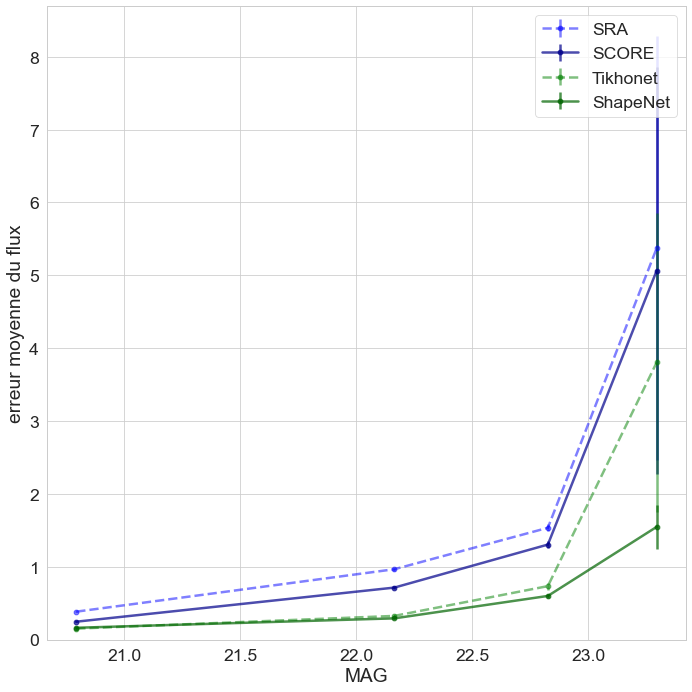

In [9]:
# set seaborn theme and style
sns.set_theme()
sns.set_context("paper", font_scale=2, rc={"lines.linewidth": 2.5})
#remove grid from images
sns.set_style("whitegrid")#, {'axes.grid' : False})

plt.figure(figsize=(10,10))
plt.errorbar(bins,flux_mean_s0,flux_std_s0/sqrt_num_gal,linestyle='--', marker='o',color=color_s0,label=label_s0,alpha=0.5)
plt.errorbar(bins,flux_mean_s1,flux_std_s1/sqrt_num_gal,linestyle='-', marker='o',color=color_s1,label=label_s1,alpha=0.7)
plt.errorbar(bins,flux_mean_g0,flux_std_g0/sqrt_num_gal,linestyle='--', marker='o',color=color_g0,label=label_g0,alpha=0.5)
plt.errorbar(bins,flux_mean_g05,flux_std_g05/sqrt_num_gal,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.7)
plt.ylim(bottom=0)
plt.xlabel(r'MAG')
plt.ylabel(r'erreur moyenne du flux')
# plt.title(r'Relative flux vs MAG')
plt.legend()
plt.tight_layout()
plt.savefig('./cfht_flux.pdf')

### Plot $g$ vs $\text{MAG}$

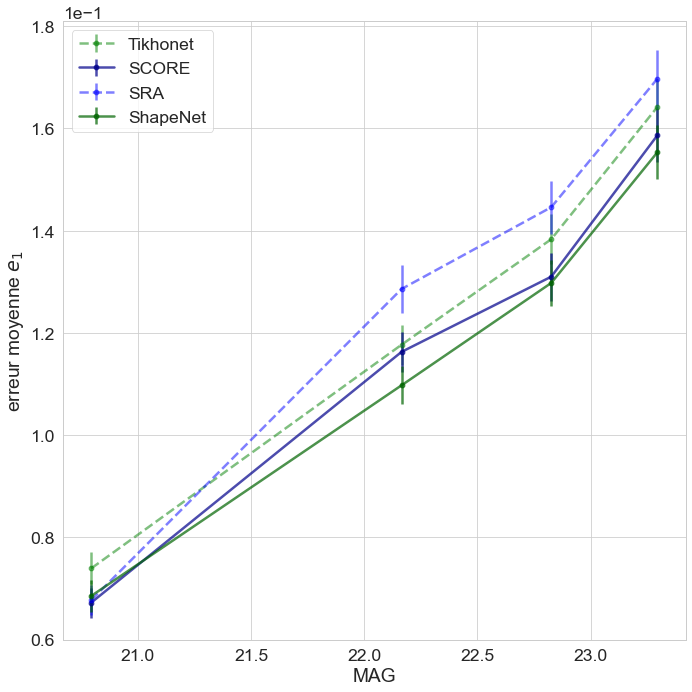

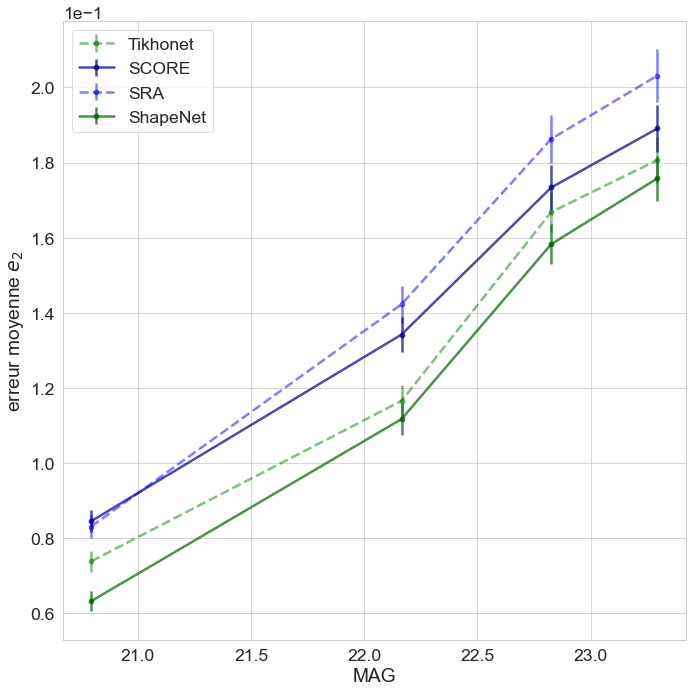

In [10]:
plt.figure(figsize=(10,10))
plt.errorbar(bins,mom_mean_g0[0],mom_std_g0[0]/sqrt_num_gal,linestyle='--', marker='o',color=color_g0,label=label_g0,alpha=0.5)
plt.errorbar(bins,mom_mean_s1[0],mom_std_s1[0]/sqrt_num_gal,linestyle='-', marker='o',color=color_s1,label=label_s1,alpha=0.7)
plt.errorbar(bins,mom_mean_s0[0],mom_std_s0[0]/sqrt_num_gal,linestyle='--', marker='o',color=color_s0,label=label_s0,alpha=0.5)
plt.errorbar(bins,mom_mean_g05[0],mom_std_g05[0]/sqrt_num_gal,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.7)
plt.ylim(bottom=0)
plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
plt.xlabel(r'MAG')
plt.ylabel(r'erreur moyenne $e_{1}$')
# plt.title(r'$g_1$ absolute RMSE vs MAG')
plt.legend()
y_min,y_max = plt.ylim()
y_min = 0.06
plt.ylim([y_min,y_max])
plt.tight_layout()
plt.savefig('./cfht_e1.pdf')

plt.figure(figsize=(10,10))
plt.errorbar(bins,mom_mean_g0[1],mom_std_g0[1]/sqrt_num_gal,linestyle='--', marker='o',color=color_g0,label=label_g0,alpha=0.5)
plt.errorbar(bins,mom_mean_s1[1],mom_std_s1[1]/sqrt_num_gal,linestyle='-', marker='o',color=color_s1,label=label_s1,alpha=0.7)
plt.errorbar(bins,mom_mean_s0[1],mom_std_s0[1]/sqrt_num_gal,linestyle='--', marker='o',color=color_s0,label=label_s0,alpha=0.5)
plt.errorbar(bins,mom_mean_g05[1],mom_std_g05[1]/sqrt_num_gal,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.7)
plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
plt.xlabel(r'MAG')
plt.ylabel(r'erreur moyenne $e_2$')
# plt.title(r'$g_2$ absolute RMSE vs MAG')
plt.legend()
plt.tight_layout()
plt.savefig('./cfht_e2.pdf')

### Plot $\text{MSE}$ vs $\text{MAG}$

<ipython-input-11-b2b5b2f44979>:10: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(bottom=0)


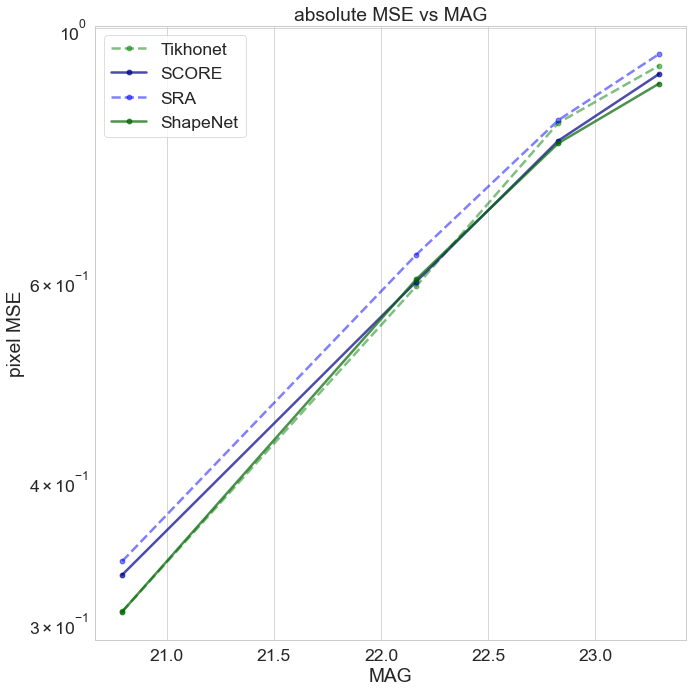

<ipython-input-11-b2b5b2f44979>:28: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(bottom=0)


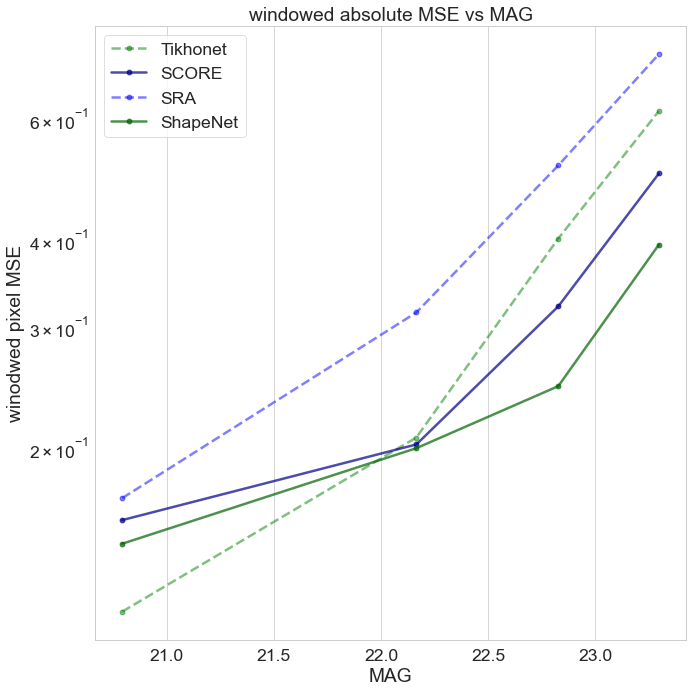

In [11]:
plt.figure(figsize=(10,10))
# plt.errorbar(bins,mse_mean_g0,mse_std_g0/sqrt_num_gal,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
# plt.errorbar(bins,mse_mean_s1,mse_std_s1/sqrt_num_gal,linestyle='-', marker='o',color=color_s1,label=label_s1,alpha=0.7)
# plt.errorbar(bins,mse_mean_s0,mse_std_s0/sqrt_num_gal,linestyle='-', marker='o',color=color_s0,label=label_s0,alpha=0.5)
# plt.errorbar(bins,mse_mean_g05,mse_std_g05/sqrt_num_gal,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.7)
plt.semilogy(bins,mse_mean_g0,linestyle='--', marker='o',color=color_g0,label=label_g0,alpha=0.5)
plt.semilogy(bins,mse_mean_s1,linestyle='-', marker='o',color=color_s1,label=label_s1,alpha=0.7)
plt.semilogy(bins,mse_mean_s0,linestyle='--', marker='o',color=color_s0,label=label_s0,alpha=0.5)
plt.semilogy(bins,mse_mean_g05,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.7)
plt.ylim(bottom=0)
#plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
plt.xlabel(r'MAG')
plt.ylabel(r'pixel MSE')
plt.title(r'absolute MSE vs MAG')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,10))
# plt.errorbar(bins,mse_mean_g0_w,mse_std_g0_w/sqrt_num_gal,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
# plt.errorbar(bins,mse_mean_s1_w,mse_std_s1_w/sqrt_num_gal,linestyle='-', marker='o',color=color_s1,label=label_s1,alpha=0.7)
# plt.errorbar(bins,mse_mean_s0_w,mse_std_s0_w/sqrt_num_gal,linestyle='-', marker='o',color=color_s0,label=label_s0,alpha=0.5)
# plt.errorbar(bins,mse_mean_g05_w,mse_std_g05_w/sqrt_num_gal,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.7)
plt.semilogy(bins,mse_mean_g0_w,linestyle='--', marker='o',color=color_g0,label=label_g0,alpha=0.5)
plt.semilogy(bins,mse_mean_s1_w,linestyle='-', marker='o',color=color_s1,label=label_s1,alpha=0.7)
plt.semilogy(bins,mse_mean_s0_w,linestyle='--', marker='o',color=color_s0,label=label_s0,alpha=0.5)
plt.semilogy(bins,mse_mean_g05_w,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.7)
plt.ylim(bottom=0)
#plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
plt.xlabel(r'MAG')
plt.ylabel(r'winodwed pixel MSE')
plt.title(r'windowed absolute MSE vs MAG')
plt.legend()
plt.tight_layout()
plt.show()

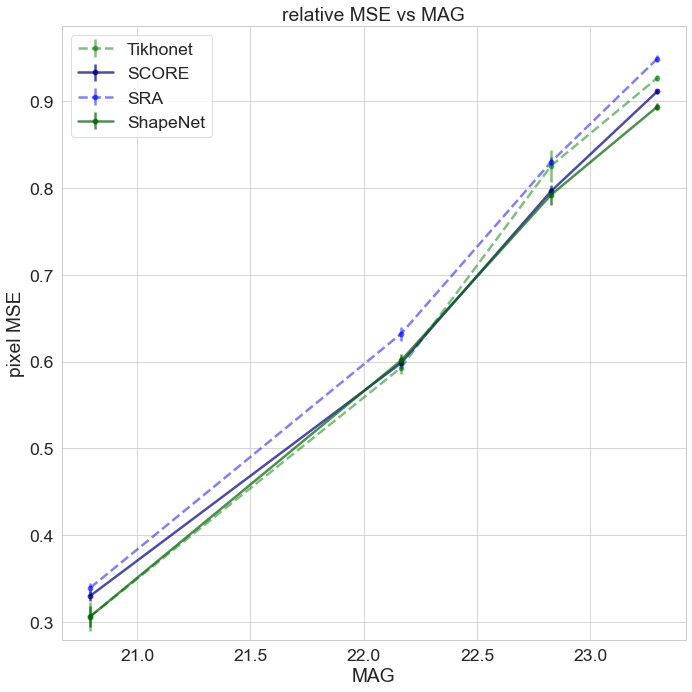

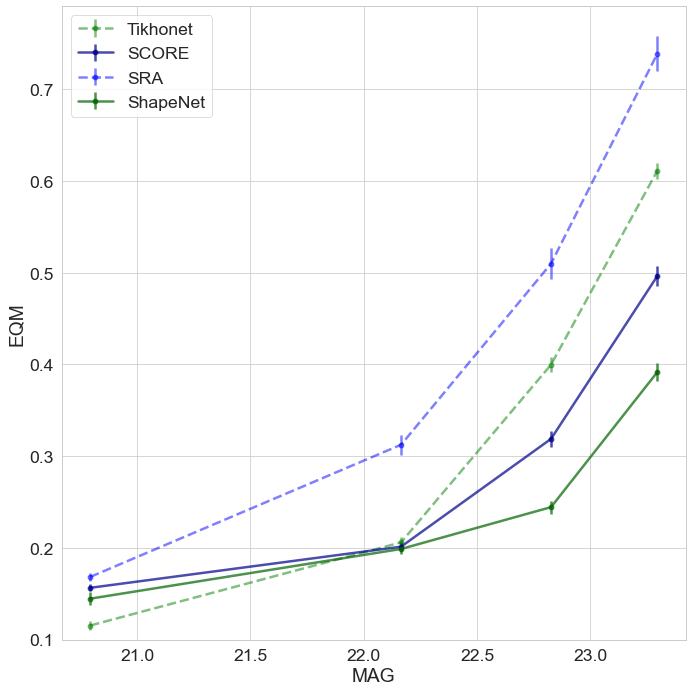

In [12]:
plt.figure(figsize=(10,10))
plt.errorbar(bins,mse_mean_g0,mse_std_g0/sqrt_num_gal,linestyle='--', marker='o',color=color_g0,label=label_g0,alpha=0.5)
plt.errorbar(bins,mse_mean_s1,mse_std_s1/sqrt_num_gal,linestyle='-', marker='o',color=color_s1,label=label_s1,alpha=0.7)
plt.errorbar(bins,mse_mean_s0,mse_std_s0/sqrt_num_gal,linestyle='--', marker='o',color=color_s0,label=label_s0,alpha=0.5)
plt.errorbar(bins,mse_mean_g05,mse_std_g05/sqrt_num_gal,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.7)
# plt.semilogy(bins,mse_mean_g0,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
# plt.semilogy(bins,mse_mean_s1,linestyle='-', marker='o',color=color_s1,label=label_s1,alpha=0.7)
# plt.semilogy(bins,mse_mean_s0,linestyle='-', marker='o',color=color_s0,label=label_s0,alpha=0.5)
# plt.semilogy(bins,mse_mean_g05,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.7)
plt.ylim(bottom=0)
#plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
plt.xlabel(r'MAG')
plt.ylabel(r'pixel MSE')
plt.title(r'relative MSE vs MAG')
plt.legend()
y_min,y_max = plt.ylim()
y_min = 0.28
plt.ylim([y_min,y_max])
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,10))
plt.errorbar(bins,mse_mean_g0_w,mse_std_g0_w/sqrt_num_gal,linestyle='--', marker='o',color=color_g0,label=label_g0,alpha=0.5)
plt.errorbar(bins,mse_mean_s1_w,mse_std_s1_w/sqrt_num_gal,linestyle='-', marker='o',color=color_s1,label=label_s1,alpha=0.7)
plt.errorbar(bins,mse_mean_s0_w,mse_std_s0_w/sqrt_num_gal,linestyle='--', marker='o',color=color_s0,label=label_s0,alpha=0.5)
plt.errorbar(bins,mse_mean_g05_w,mse_std_g05_w/sqrt_num_gal,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.7)
# plt.semilogy(bins,mse_mean_g0_w,linestyle='-', marker='o',color=color_g0,label=label_g0,alpha=0.5)
# plt.semilogy(bins,mse_mean_s1_w,linestyle='-', marker='o',color=color_s1,label=label_s1,alpha=0.7)
# plt.semilogy(bins,mse_mean_s0_w,linestyle='-', marker='o',color=color_s0,label=label_s0,alpha=0.5)
# plt.semilogy(bins,mse_mean_g05_w,linestyle='-', marker='o',color=color_g05,label=label_g05,alpha=0.7)
plt.ylim(bottom=0)
#plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
plt.xlabel(r'MAG')
plt.ylabel(r'EQM')
# plt.title(r'windowed relative MSE vs MAG')
plt.legend()
y_min,y_max = plt.ylim()
y_min = 0.1
plt.ylim([y_min,y_max])
plt.tight_layout()
plt.savefig('./cfht_mse.pdf')

### Make Table for Global Performance

In [13]:
n_batch = window_flags.size
sqrt_n_batch = np.sqrt(n_batch)

# compute pixel errors
mse_g0_mean = np.mean(mse_g0_win)
mse_s1_mean = np.mean(mse_s1_win)
mse_s0_mean = np.mean(mse_s0_win)
mse_g05_mean = np.mean(mse_g05_win)

mse_g0_std = np.std(mse_g0_win)/sqrt_n_batch
mse_s1_std = np.std(mse_s1_win)/sqrt_n_batch
mse_s0_std = np.std(mse_s0_win)/sqrt_n_batch
mse_g05_std = np.std(mse_g05_win)/sqrt_n_batch

# compute winodwed relative pixel errors
mse_w_g0_mean = np.mean(mse_g0_win_w)
mse_w_s1_mean = np.mean(mse_s1_win_w)
mse_w_s0_mean = np.mean(mse_s0_win_w)
mse_w_g05_mean = np.mean(mse_g05_win_w)

mse_w_g0_std = np.std(mse_g0_win_w)/sqrt_n_batch
mse_w_s1_std = np.std(mse_s1_win_w)/sqrt_n_batch
mse_w_s0_std = np.std(mse_s0_win_w)/sqrt_n_batch
mse_w_g05_std = np.std(mse_g05_win_w)/sqrt_n_batch

# compute adapative moments errors
mom1_err_g0_mean = np.mean(mom_err_g0_win[0])
mom1_err_s1_mean = np.mean(mom_err_s1_win[0])
mom1_err_s0_mean = np.mean(mom_err_s0_win[0])
mom1_err_g05_mean = np.mean(mom_err_g05_win[0])

mom1_err_g0_std = np.std(mom_err_g0_win[0])/sqrt_n_batch
mom1_err_s1_std = np.std(mom_err_s1_win[0])/sqrt_n_batch
mom1_err_s0_std = np.std(mom_err_s0_win[0])/sqrt_n_batch
mom1_err_g05_std = np.std(mom_err_g05_win[0])/sqrt_n_batch

mom2_err_g0_mean = np.mean(mom_err_g0_win[1])
mom2_err_s1_mean = np.mean(mom_err_s1_win[1])
mom2_err_s0_mean = np.mean(mom_err_s0_win[1])
mom2_err_g05_mean = np.mean(mom_err_g05_win[1])

mom2_err_g0_std = np.std(mom_err_g0_win[1])/sqrt_n_batch
mom2_err_s1_std = np.std(mom_err_s1_win[1])/sqrt_n_batch
mom2_err_s0_std = np.std(mom_err_s0_win[1])/sqrt_n_batch
mom2_err_g05_std = np.std(mom_err_g05_win[1])/sqrt_n_batch

# compute fluxipticity errors
flux_err_g0_mean = np.mean(np.abs(flux_err_g0_win))
flux_err_s1_mean = np.mean(np.abs(flux_err_s1_win))
flux_err_s0_mean = np.mean(np.abs(flux_err_s0_win))
flux_err_g05_mean = np.mean(np.abs(flux_err_g05_win))

flux_err_g0_std = np.std(np.abs(flux_err_g0_win))/sqrt_n_batch
flux_err_s1_std = np.std(np.abs(flux_err_s1_win))/sqrt_n_batch
flux_err_s0_std = np.std(np.abs(flux_err_s0_win))/sqrt_n_batch
flux_err_g05_std = np.std(np.abs(flux_err_g05_win))/sqrt_n_batch

In [14]:
def draw_table(text_list):
    part1 = """\\begin{table}[h!]
\\resizebox{\\textwidth}{!}{
\\begin{tabular}{|l||l|l|l|l|}
\hline
"""
    part2 = """{0} & {1}  & {2} & {3} & {4} \\\ \hline
{5} & {6}  & {7} & {8} & {9} \\\\
{10} & {11}  & {12} & {13} & {14} \\\\
{15} & {16}  & {17} & {18} & {19} \\\\
{20} & {21}  & {22} & {23} & {24} \\\ \hline
""".format(*text_list)
    
    part3 = """\end{tabular}
}
\end{table}"""
    
    return part1+part2+part3
    
def latex_float(f):
    float_str = "{:.2e}".format(f)
    base, exponent = float_str.split("e")
    base = list(base)
    base[1] = ','
    base = "".join(base)
    return r"{0} . 10^{{{1}}}".format(base, int(exponent))

def latex_float_err(value,err):
    return r'${0} \pm {1}$'.format(latex_float(value),latex_float(err))

In [15]:
header = ["M\\'{e}thodes", 'EQM', 'flux', '$e_1$', '$e_2$']
methods = ['SRA', 'SCORE', 'Tikhonet', 'Tikhonet CF']
means = [mse_w_s0_mean,mse_w_s1_mean,mse_w_g0_mean,mse_w_g05_mean,
         flux_err_s0_mean,flux_err_s1_mean,flux_err_g0_mean,flux_err_g05_mean,
         mom1_err_s0_mean,mom1_err_s1_mean,mom1_err_g0_mean,mom1_err_g05_mean,
         mom2_err_s0_mean,mom2_err_s1_mean,mom2_err_g0_mean,mom2_err_g05_mean]
stds = [mse_w_s0_std,mse_w_s1_std,mse_w_g0_std,mse_w_g05_std,
        flux_err_s0_std,flux_err_s1_std,flux_err_g0_std,flux_err_g05_std,
        mom1_err_s0_std,mom1_err_s1_std,mom1_err_g0_std,mom1_err_g05_std,
        mom2_err_s0_std,mom2_err_s1_std,mom2_err_g0_std,mom2_err_g05_std]

text_list = header + []

for ind,method in enumerate(methods):
    text_list += [method]
    for j in range(4):
        text_list += [latex_float_err(means[4*j+ind],stds[4*j+ind])]

print(draw_table(text_list))

\begin{table}[h!]
\resizebox{\textwidth}{!}{
\begin{tabular}{|l||l|l|l|l|}
\hline
M\'{e}thodes & EQM  & flux & $e_1$ & $e_2$ \\ \hline
SRA & $4,33 . 10^{-1} \pm 6,95 . 10^{-3}$  & $2,06 . 10^{0} \pm 5,92 . 10^{-1}$ & $1,28 . 10^{-1} \pm 2,03 . 10^{-3}$ & $1,54 . 10^{-1} \pm 2,41 . 10^{-3}$ \\
SCORE & $2,93 . 10^{-1} \pm 3,93 . 10^{-3}$  & $1,83 . 10^{0} \pm 5,68 . 10^{-1}$ & $1,18 . 10^{-1} \pm 1,84 . 10^{-3}$ & $1,45 . 10^{-1} \pm 2,20 . 10^{-3}$ \\
Tikhonet & $3,33 . 10^{-1} \pm 4,45 . 10^{-3}$  & $1,25 . 10^{0} \pm 4,16 . 10^{-1}$ & $1,24 . 10^{-1} \pm 1,89 . 10^{-3}$ & $1,34 . 10^{-1} \pm 2,09 . 10^{-3}$ \\
Tikhonet CF & $2,45 . 10^{-1} \pm 3,47 . 10^{-3}$  & $6,49 . 10^{-1} \pm 6,20 . 10^{-2}$ & $1,16 . 10^{-1} \pm 1,81 . 10^{-3}$ & $1,27 . 10^{-1} \pm 2,06 . 10^{-3}$ \\ \hline
\end{tabular}
}
\end{table}


In [16]:
bins

[20.793262, 22.164833, 22.826544, 23.29574]

In [17]:
gal_num

NameError: name 'gal_num' is not defined

In [ ]:
sqrt_num_gal

In [ ]:
22.5**2

In [ ]:
n_batch

In [ ]:
mom_mean_g0[0][0],mom_mean_s0[0][0]

In [ ]:
(mom_mean_g0[0][0]-mom_mean_s0[0][0])/mom_mean_s0[0][0]

In [ ]:
mom_std_g0[0][0]/sqrt_num_gal[0],mom_std_s0[0][0]/sqrt_num_gal[0]